In [3]:
import sys

sys.path.append('..')

In [4]:
import torch

data = torch.load('../processed_data/complete_dataset/processed_data.pt')
label = torch.load('../processed_data/complete_dataset/processed_label.pt')

In [12]:
data

tensor([[[[-2.4064e+02, -2.1121e+02, -1.9391e+02,  ..., -6.5820e+01,
           -8.3363e+01, -9.6638e+01],
          [ 9.9648e+01,  1.0104e+02,  1.0224e+02,  ...,  1.3565e+02,
            1.4059e+02,  1.5314e+02],
          [-7.4033e+00, -8.3585e+00,  1.9154e+00,  ..., -5.4715e+01,
           -5.9680e+01, -6.2792e+01],
          ...,
          [ 1.4372e+01,  1.6239e+01,  1.8175e+01,  ..., -7.2889e+00,
           -6.3519e+00, -9.4891e+00],
          [-2.2281e+00, -4.0962e+00, -9.1850e+00,  ..., -1.1322e+01,
           -1.2176e+01, -1.4455e+01],
          [-3.9805e+00,  1.0718e+00, -2.1272e+00,  ...,  6.2954e+00,
            7.2154e+00,  8.2723e+00]],

         [[ 1.0456e+01,  1.0456e+01,  1.0456e+01,  ...,  2.4230e+00,
           -2.4604e+00, -2.4604e+00],
          [ 1.8030e+00,  1.8030e+00,  1.8030e+00,  ...,  1.3328e+00,
           -9.0100e-02, -9.0100e-02],
          [-3.3499e+00, -3.3499e+00, -3.3499e+00,  ..., -7.4006e-01,
            2.0892e+00,  2.0892e+00],
          ...,
     

In [5]:
from audio_toolbox.metrics import audio_dataset_split

RANDOM_STATE = 42
X_train, y_train, _, _,\
X_test, y_test = audio_dataset_split(data, label, train_val_test_ratio=(0.9, 0, 0.1), random_state=RANDOM_STATE)

In [6]:
X_train_flat = X_train.view(X_train.shape[0], -1).cpu().numpy()
X_test_flat = X_test.view(X_test.shape[0], -1).cpu().numpy()

Do PCA on flattened features

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize the scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components=0.9)  # Keep 90% of the variance

# Fit the scaler on the training set and transform all sets
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

reduced_X_train_flat = pca.fit_transform(X_train_scaled)
reduced_X_test_flat = pca.transform(X_test_scaled)

In [8]:
X_train = X_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()

In [9]:
print(f"Training samples: {X_train_flat.shape} -> {reduced_X_train_flat.shape}")
print(f"Test samples: {X_test_flat.shape} -> {reduced_X_test_flat.shape}")

Training samples: (899, 92880) -> (899, 661)
Test samples: (100, 92880) -> (100, 661)


In [11]:
reduced_X_test_flat


array([[-18.6759    ,  57.38724   ,  13.262023  , ...,   2.151938  ,
         -0.51704264,  -2.8087175 ],
       [ 67.61186   , -42.754498  ,  19.059381  , ...,  -2.9901767 ,
          1.8806312 ,  -0.57618964],
       [-50.10816   ,  21.624231  ,  -2.9635477 , ...,   2.2713196 ,
         -0.89786476,   0.11771658],
       ...,
       [-28.794216  , -76.076035  , -24.80688   , ...,  -1.6788018 ,
         -4.2666583 ,   2.8156047 ],
       [ 76.93399   ,  13.940415  , -16.73685   , ...,  -2.4317627 ,
          0.84761363,   0.09487524],
       [ 65.7724    , -14.404846  ,  10.453078  , ...,  -4.633902  ,
          3.2122395 ,   3.8099163 ]], dtype=float32)

In [10]:
from sklearn.linear_model import LogisticRegression
from audio_toolbox.metrics import calculate_acc, precision_recall

logistic_model = LogisticRegression(max_iter=1000, C=1e-2, random_state=RANDOM_STATE)
logistic_model.fit(reduced_X_train_flat, y_train)
print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(logistic_model, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(logistic_model, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 61.0000%, 39 mismatches out of 100 samples
(Averaged) Test precision: 0.6067, recall: 0.6346, f1 score: 0.5883


In [9]:
from sklearn.svm import SVC

svm_classifier = SVC(C=1e-3, random_state=RANDOM_STATE)
svm_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(svm_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(svm_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 18.7987%, 730 mismatches out of 899 samples
(Averaged) Train precision: 0.3354, recall: 0.1798, f1 score: 0.0869
Test accuracy: 6.0000%, 94 mismatches out of 100 samples
(Averaged) Test precision: 0.0462, recall: 0.1000, f1 score: 0.0169


In [10]:
ovo_svm = SVC(decision_function_shape='ovo', random_state=RANDOM_STATE)
ovo_svm.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(ovo_svm, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(ovo_svm, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 98.5539%, 13 mismatches out of 899 samples
(Averaged) Train precision: 0.9858, recall: 0.9856, f1 score: 0.9856
Test accuracy: 30.0000%, 70 mismatches out of 100 samples
(Averaged) Test precision: 0.5190, recall: 0.3417, f1 score: 0.2150


In [11]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(n_estimators=100,
                                                max_depth=4,
                                                random_state=RANDOM_STATE)
rand_forest_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(rand_forest_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(rand_forest_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 83.2036%, 151 mismatches out of 899 samples
(Averaged) Train precision: 0.8446, recall: 0.8304, f1 score: 0.8311
Test accuracy: 27.0000%, 73 mismatches out of 100 samples
(Averaged) Test precision: 0.2973, recall: 0.3142, f1 score: 0.1790


In [12]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([X_train_flat, X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(gnb_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 84.4271%, 140 mismatches out of 899 samples
(Averaged) Train precision: 0.8648, recall: 0.8436, f1 score: 0.8448
Test accuracy: 61.0000%, 39 mismatches out of 100 samples
(Averaged) Test precision: 0.6451, recall: 0.6508, f1 score: 0.6162


In [13]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(gnb_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 57.9533%, 378 mismatches out of 899 samples
(Averaged) Train precision: 0.6591, recall: 0.5800, f1 score: 0.5631
Test accuracy: 13.0000%, 87 mismatches out of 100 samples
(Averaged) Test precision: 0.4229, recall: 0.1250, f1 score: 0.0650


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost_classifier = GradientBoostingClassifier(subsample=0.8, max_depth=2, random_state=RANDOM_STATE)
xgboost_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(xgboost_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 99.6663%, 3 mismatches out of 899 samples
(Averaged) Train precision: 0.6591, recall: 0.5800, f1 score: 0.5631
Test accuracy: 44.0000%, 56 mismatches out of 100 samples
(Averaged) Test precision: 0.4229, recall: 0.1250, f1 score: 0.0650


Prepare dataset for K fold 

In [15]:
data_flat = data.view(data.shape[0], -1).cpu().numpy()
data_scaled = scaler.fit_transform(data_flat)
reduced_data = pca.fit_transform(data_scaled)

In [26]:
#Training xgboost classifier takes more time. For quick testing, feel free to delete it from the list
#current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier, xgboost_classifier] 
current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier]
#current_model_names = ["logistic", "svm", "ovo_svm", "rand_forest_classifier", "gnb_classifier", "xgboost_classifier"]
current_model_names = ["logistic", "svm", "ovo_svm", "rand_forest_classifier", "gnb_classifier"]

In [27]:
from audio_toolbox.metrics import kfold_validation

N_SPLITS = 5

accs = {}

for model, name in zip(current_models, current_model_names):
    print(f"Benchmarking {name}")
    avg_acc, avg_precision, avg_recall, avg_f1 = kfold_validation(model, reduced_data, label, n_splits=N_SPLITS)
    accs[name] = avg_acc
    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("\n")


Benchmarking logistic
Average Accuracy: 46.3467
Average Precision: 0.8953
Average Recall: 0.8921
Average F1 Score: 0.8921


Benchmarking svm
Average Accuracy: 43.4387
Average Precision: 0.7058
Average Recall: 0.6863
Average F1 Score: 0.6511


Benchmarking ovo_svm
Average Accuracy: 56.2518
Average Precision: 0.9039
Average Recall: 0.9017
Average F1 Score: 0.9013


Benchmarking rand_forest_classifier
Average Accuracy: 43.0417
Average Precision: 0.8019
Average Recall: 0.7877
Average F1 Score: 0.7858


Benchmarking gnb_classifier
Average Accuracy: 35.2352
Average Precision: 0.6438
Average Recall: 0.5602
Average F1 Score: 0.5436




In [38]:
import matplotlib.pyplot as plt
import numpy as np
def create_bar_chart(data, title, ylabel):
    models = list(data.keys())
    scores = list(data.values())
    fig, ax = plt.subplots()
    bar_positions = np.arange(len(models))
    ax.bar(bar_positions, scores, color='skyblue')
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

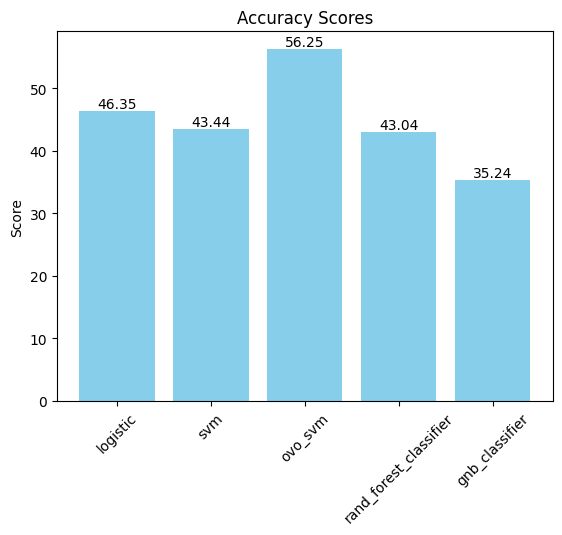

In [39]:
create_bar_chart(accs, "Accuracy Scores", "Score")